In [1]:
%%R
library(reticulate)
use_condaenv('ethique_env')

UsageError: Cell magic `%%R` not found.


# Fairness 

Pour mesurer la partialité d'un algorithme plusieurs métriques ont été proposées. La parité démographique, la parité proportionnelle et l'égalité des chances sont les plus communes pour évaluer la partialité sur les variables sensibles comme le sex ou la nationalité lorsque le modèle est un classifieur binaire. Il existe un très grands nombre d'autre métiques qui dépendent de la matrice de confusion. 

Pour illustrer cela nous allons utilisé dans un premier temps les calculers avec les formules explicites puis nous utiliserons la librairie : *AI Fairness 360*.

## Prépration des données et création du modèle cible

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from copy import deepcopy

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
seed = 2021

In [3]:
credit = pd.read_csv("data/german_credit_prepared.csv", sep=",", engine="python")

y = credit.default 
X = credit.drop(columns=["default"])

# Définie quelles colones sont categorielles et quelles sont continue
variables_cat = [col for col in X.columns if credit[col].dtype==object]
variables_ord = [col for col in X.columns if credit[col].dtype==int]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), variables_cat),
        ('ord', StandardScaler(), variables_ord)
    ])

model = Pipeline(
        [
            ('preprocession', preprocess),
            ('logreg', LogisticRegression())
        ]
)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=seed)

logreg = model.fit(X_train, y_train)

## Utilisation de la matrice de confusion

La majorité des mesures de partialité sont basées sur la matrice de confusion. Elle comporte quatre classes :
 - Vrai positif (VP) : la vraie classe est 1 et la classe prédite est 1
 - Faux positif (FP) : la vraie classe est 0 et la classe prédite est 1 
 - Vrai négatif (VN) : la vraie classe est 0 et la classe prédite est 0
 - Faux négatif (FN) : la vraie classe est 1 et la classe prédite est 0

Les métriques de partialité sont calculé à partir de ces 4 valeurs pour des groupes de personnes partagants des caractéristiques communes (sex, ethnicité) 

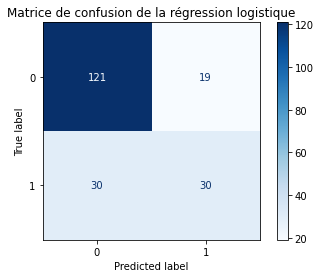

In [5]:
title = 'Matrice de confusion de la régression logistique'
disp = plot_confusion_matrix(logreg,
                             X_test,
                             y_test,
                             cmap=plt.cm.Blues)
disp.ax_.set_title(title)
plt.show()

## Métriques de parité

In [6]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

In [7]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index, name='defaut')
y_test = pd.Series(y_test, index=X_test.index, name='defaut')
sex_test = X_test.sex.map({'male': 0, 'female': 1})

bld_test_pred = BinaryLabelDataset(df=pd.concat([y_test_pred, sex_test], axis=1),
                                                label_names=['defaut'], 
                                                protected_attribute_names=['sex'],
                                                favorable_label=0, unfavorable_label=1)
bld_test = BinaryLabelDataset(df=pd.concat([y_test, sex_test], axis=1),
                                           label_names=['defaut'], 
                                           protected_attribute_names=['sex'],
                                           favorable_label=0, unfavorable_label=1)

In [8]:
fairness_metrics = ClassificationMetric(bld_test, bld_test_pred, 
                         unprivileged_groups=[{'sex': 1}], privileged_groups=[{'sex': 0}])

Average of difference in FPR and TPR for unprivileged and privileged
groups:

   $$\tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}})
   + (TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}))\right]$$

A value of 0 indicates equality of odds.

In [9]:
fairness_metrics.average_odds_difference()

-0.14944444444444446

$$Pr(\hat{Y} = 1 | D = \text{unprivileged})
   - Pr(\hat{Y} = 1 | D = \text{privileged})$$

In [10]:
fairness_metrics.statistical_parity_difference()

-0.19117647058823528

$$TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}$$

In [11]:
fairness_metrics.true_positive_rate_difference()

-0.16000000000000003

$$\frac{Pr(\hat{Y} = 1 | D = \text{unprivileged})}
   {Pr(\hat{Y} = 1 | D = \text{privileged})}$$

In [12]:
fairness_metrics.disparate_impact()

0.7657657657657658

In [13]:
fairness_metrics.accuracy()

0.755

## Post Processing

http://www.datasciencepublicpolicy.org/wp-content/uploads/2021/04/Fairness-Full-Tree.png

In [14]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [15]:
cpp = CalibratedEqOddsPostprocessing(unprivileged_groups=[{'sex': 1}], 
                                   privileged_groups=[{'sex': 0}],
                                   cost_constraint='fpr')

In [16]:
cpp = cpp.fit(bld_test, bld_test_pred)

In [17]:
bld_test_pred = cpp.predict(bld_test_pred)

In [18]:
fairness_metrics = ClassificationMetric(bld_test, bld_test_pred, 
                         unprivileged_groups=[{'sex': 1}], privileged_groups=[{'sex': 0}])

In [19]:
fairness_metrics.average_odds_difference()

0.1338888888888889

In [20]:
fairness_metrics.statistical_parity_difference()

0.05882352941176472

In [21]:
fairness_metrics.true_positive_rate_difference()

-0.010000000000000009

In [22]:
fairness_metrics.disparate_impact()

1.072072072072072

In [23]:
fairness_metrics.accuracy()

0.735

## Pre Processing

In [24]:
from aif360.algorithms.preprocessing import Reweighing

In [25]:
rw = Reweighing(unprivileged_groups=[{'sex': 1}], 
                privileged_groups=[{'sex': 0}])

In [26]:
if 'sex' in variables_cat: variables_cat.remove('sex')

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), variables_cat),
        ('ord', StandardScaler(), variables_ord)
    ])

X_train_proc = preprocess.fit_transform(X_train.drop(columns='sex'))
X_train_proc = pd.concat([pd.DataFrame(X_train_proc, index=X_train.index), 
                          X_train.sex.map({'male':0, 'female':1})], axis=1)

In [30]:
bld_train = BinaryLabelDataset(df=pd.concat([X_train_proc, y_train], axis=1),
                                                label_names=['default'], 
                                                protected_attribute_names=['sex'],
                                                favorable_label=0, unfavorable_label=1)

In [31]:
bld_train = rw.fit_transform(bld_train)

In [32]:
w_train = bld_train.instance_weights.ravel()

In [33]:
model.fit(X_train, y_train, logreg__sample_weight = w_train)

Pipeline(steps=[('preprocession',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['account_check_status',
                                                   'credit_history', 'purpose',
                                                   'savings',
                                                   'present_emp_since',
                                                   'personal _status',
                                                   'other_debtors', 'property',
                                                   'other_installment_plans',
                                                   'housing', 'job',
                                                   'telephone',
                                                   'foreign_worker']),
                                                 ('ord', StandardScaler(),
                                 

In [34]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index, name='defaut')
y_test = pd.Series(y_test, index=X_test.index, name='defaut')
sex_test = X_test.sex.map({'male': 0, 'female':1})

In [36]:

bld_test_pred = BinaryLabelDataset(df=pd.concat([y_test_pred, sex_test], axis=1),
                                                label_names=['defaut'], 
                                                protected_attribute_names=['sex'],
                                                favorable_label=0, unfavorable_label=1)
bld_test = BinaryLabelDataset(df=pd.concat([y_test, sex_test], axis=1),
                                           label_names=['defaut'], 
                                           protected_attribute_names=['sex'],
                                           favorable_label=0, unfavorable_label=1)

In [37]:
fairness_metrics = ClassificationMetric(bld_test, bld_test_pred, 
                         unprivileged_groups=[{'sex': 1}], privileged_groups=[{'sex': 0}])

In [38]:
fairness_metrics.average_odds_difference()

-0.09222222222222223

In [39]:
fairness_metrics.statistical_parity_difference()

-0.13786764705882348

In [40]:
fairness_metrics.true_positive_rate_difference()

-0.11499999999999999

In [41]:
fairness_metrics.disparate_impact()

0.826388888888889

In [42]:
fairness_metrics.accuracy()

0.75